# SAUC Summer EDA

__Author:__ Pat McCornack

__Date:__ 12/17/24

__Purpose:__ Exploratory data analysis of the Sauces Canyon dataset for summer months. Summer months are the time when fog is most ecologically limited, and the fog data is not confounded by winter rains. 

In [63]:
import os
import numpy as np
import pandas as pd

import datetime as dt
from datetime import datetime
from datetime import date
import calendar

from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import matplotlib.colors as mc
from matplotlib.cm import ScalarMappable

import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set_style('whitegrid')

##  Functions


In [51]:
# Month elements of fog timing heat maps
def single_plot(data, month, year, ax, min_fog, max_fog):

    data = data[(data["time (PST)"].dt.year == year) & (data["time (PST)"].dt.month == month)]

    hour = data["time (PST)"].dt.hour
    day = data["time (PST)"].dt.day
    fog = data["fog tips"]
    fog = fog.values.reshape(24, len(day.unique()), order="F")
    
    xgrid = np.arange(day.max() + 1) + 1
    ygrid = np.arange(25)

    
    ax.pcolormesh(xgrid, ygrid, fog, cmap="magma", vmin=min_fog, vmax=max_fog)
    # Invert the vertical axis
    ax.set_ylim(24, 0)
    # Set tick positions for both axes
    ax.yaxis.set_ticks([i for i in range(24)])
    ax.xaxis.set_ticks([10, 20, 30])
    # Remove ticks by setting their length to 0
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    
    # Set larger font sizes for tick labels
    ax.tick_params(axis='both', labelsize=12)  # Adjust as needed for tick labels

    # Remove all spines
    ax.set_frame_on(False)

# Create figure displaying timing of fog drip events
def plot_hourly_heatmap(df, year, min_fog, max_fog):
    fig, axes = plt.subplots(1, 5, figsize=(7, 5), sharey=True)

    # Plot Figure
    for j, month in enumerate(range(5, 10)):
        single_plot(df, month, year, axes[j], min_fog, max_fog)
        axes[j].set(ylabel='Hour',
                    xlabel='Day')
        axes[j].set_title(calendar.month_name[month], fontsize=17)

    fig.subplots_adjust(left=0.05, right=0.98, top=0.9, hspace=0.08, wspace=0.04)

    # Create Legend
    fig.subplots_adjust(bottom=0.15)
    cbar_ax = fig.add_axes([0.3, 0.05, 0.4, 0.025])
    norm = mc.Normalize(min_fog, max_fog)

    cb = fig.colorbar(
        ScalarMappable(norm=norm, cmap="magma"), 
        cax=cbar_ax, # Pass the new axis
        orientation = "horizontal"
    )
    cb.ax.xaxis.set_tick_params(size=0)

    cb.set_label("Fog Tips", size=12)
    fig.suptitle(year)
    plt.show()

def plot_cumsum(df, year):
        df = df.set_index('time (PST)')
        df.index = pd.to_datetime(df.index)
        df = df[f'{year-1}-10-01':f'{year}-09-30']

        # Get cumulative sums
        df['fog_cumsum'] = df['fog tips'].cumsum()
        df['rain_cumsum'] = df['rain (mm)'].cumsum()

        df = df[['fog_cumsum', 'rain_cumsum']]
        ax = sns.lineplot(data=df,
                x='time (PST)',
                y='fog_cumsum',
                label='fog',
                legend=False)
        ax.set_ylim(0, 3500)

        ax2 = plt.twinx()
        sns.lineplot(data=df,
                x='time (PST)',
                y='rain_cumsum',
                ax=ax2,
                color='orange',
                label='rain',
                legend=False)

        ax.figure.legend(loc='upper left', bbox_to_anchor=(0.15, 0.85))

        ax.set(ylabel='Fog Tip Count',
                xlabel='Date',
                title=f'Fog/Rain Cumulative Sums\n{year} Water Year\n{df.attrs['site']}')
        ax2.set(ylabel='Rain')
        ax2.set_ylim(0,28)

        plt.show()

# Script Parameters

In [5]:
src_dir = '/Users/patmccornack/Documents/ucsb_fog_project/SCI_Fog_Project_Repo/data/02_clean/met-station'
src_fname = 'sauc-summer-clean-2003-2008.csv'
src_fpath = os.path.join(src_dir, src_fname)

# Exploratory Data Analysis 

In [34]:
#### Read in and prepare data #### 
df = pd.read_csv(src_fpath, index_col=0)
df['time (PST)'] = pd.to_datetime(df['time (PST)'])

# Create condition variable
df['condition'] = 'clear'
for index, row in df.iterrows():
    condition='clear'
    if row['fog'] > 0:
        df.loc[index, 'condition'] = 'fog'

    if row['rain (mm)'] > 0:
        df.loc[index, 'condition'] = 'rain'
    
    if (row['rain (mm)'] > 0) & (row['fog'] > 0):
        df.loc[index, 'condition'] = 'both'

# Set attributes
df.attrs['site'] = 'Sauces Canyon'

df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 87850 entries, 0 to 87849
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   time (PST)              87850 non-null  datetime64[ns]
 1   fog                     87850 non-null  float64       
 2   air temperature (C)     87849 non-null  float64       
 3   relative humidity (%)   87849 non-null  float64       
 4   wind speed (m/s)        44064 non-null  float64       
 5   wind gust (m/s)         87849 non-null  float64       
 6   wind direction (deg)    87850 non-null  float64       
 7   rain (mm)               87850 non-null  float64       
 8   solar radiation (kwm2)  64075 non-null  float64       
 9   leaf wetness (mv)       44035 non-null  float64       
 10  fog tips                87850 non-null  float64       
 11  condition               87850 non-null  object        
dtypes: datetime64[ns](1), float64(10), object(1)
memory

In [16]:
df.describe()

,time (PST),fog,air temperature (C),relative humidity (%),wind speed (m/s),wind gust (m/s),wind direction (deg),rain (mm),solar radiation (kwm2),leaf wetness (mv),fog tips
count,87850,87850.00,87849.00,87849.00,44064.00,87849.00,87850.00,87850.00,64075.00,44035.00,87850.00
mean,2007-01-14 18:17:57.694934528,0.64,14.98,81.86,2.01,2.65,269.09,0.00,0.26,16124.78,0.14
min,2004-05-01 00:00:00,0.00,6.54,3.70,0.00,0.00,0.00,0.00,0.00,-101.00,0.00
25%,2005-07-15 18:33:45,0.00,11.79,72.20,0.92,1.55,277.21,0.00,0.00,28.56,0.00
50%,2006-09-29 13:07:30,0.00,13.70,89.10,1.98,2.59,321.30,0.00,0.03,745.19,0.00
75%,2008-07-17 05:11:15,0.00,17.34,96.50,2.99,3.75,325.90,0.00,0.54,12523.00,0.00
max,2009-09-30 23:45:00,174.42,40.67,100.00,9.07,10.70,359.50,3.20,1.05,99999.00,37.00
std,NaN,2.93,4.59,19.12,1.34,1.56,101.02,0.03,0.33,30424.36,0.62


## Class Value Counts
The vast majority of the dataset is clear. Fog is scarce, comprising ~7% of the dataset. Rain and combined rain/fog conditions are rare enough to be negligible. 


In [17]:
#### Check relative frequency of rain/fog ####
print(f'Class Value Counts: {df['condition'].value_counts()}\n')
print(f'Class Value proportions: {df['condition'].value_counts(normalize=True).round(3)}')


Class Value Counts: condition
clear    81248
fog       6343
both       168
rain        91
Name: count, dtype: int64

Class Value proportions: condition
clear   0.93
fog     0.07
both    0.00
rain    0.00
Name: proportion, dtype: float64


## Box Plots
Given the low frequency of rain, drop observations classed as 'rain' or 'both' in order to focus on examining the difference between fog/clear conditions. Note the sample size for fog is much lower than that for 'clear', and that this methodology won't identify nonproductive (i.e. no fog drip) events. 

Note that there are very low values for RH in observations labeled 'fog' (~55% RH), these may be drops that had condensed on the harp during the event but did not 'drip' until after the event. 

Regarding solar radiation, the fog mostly occurs at night when the solar radiation value is 0.



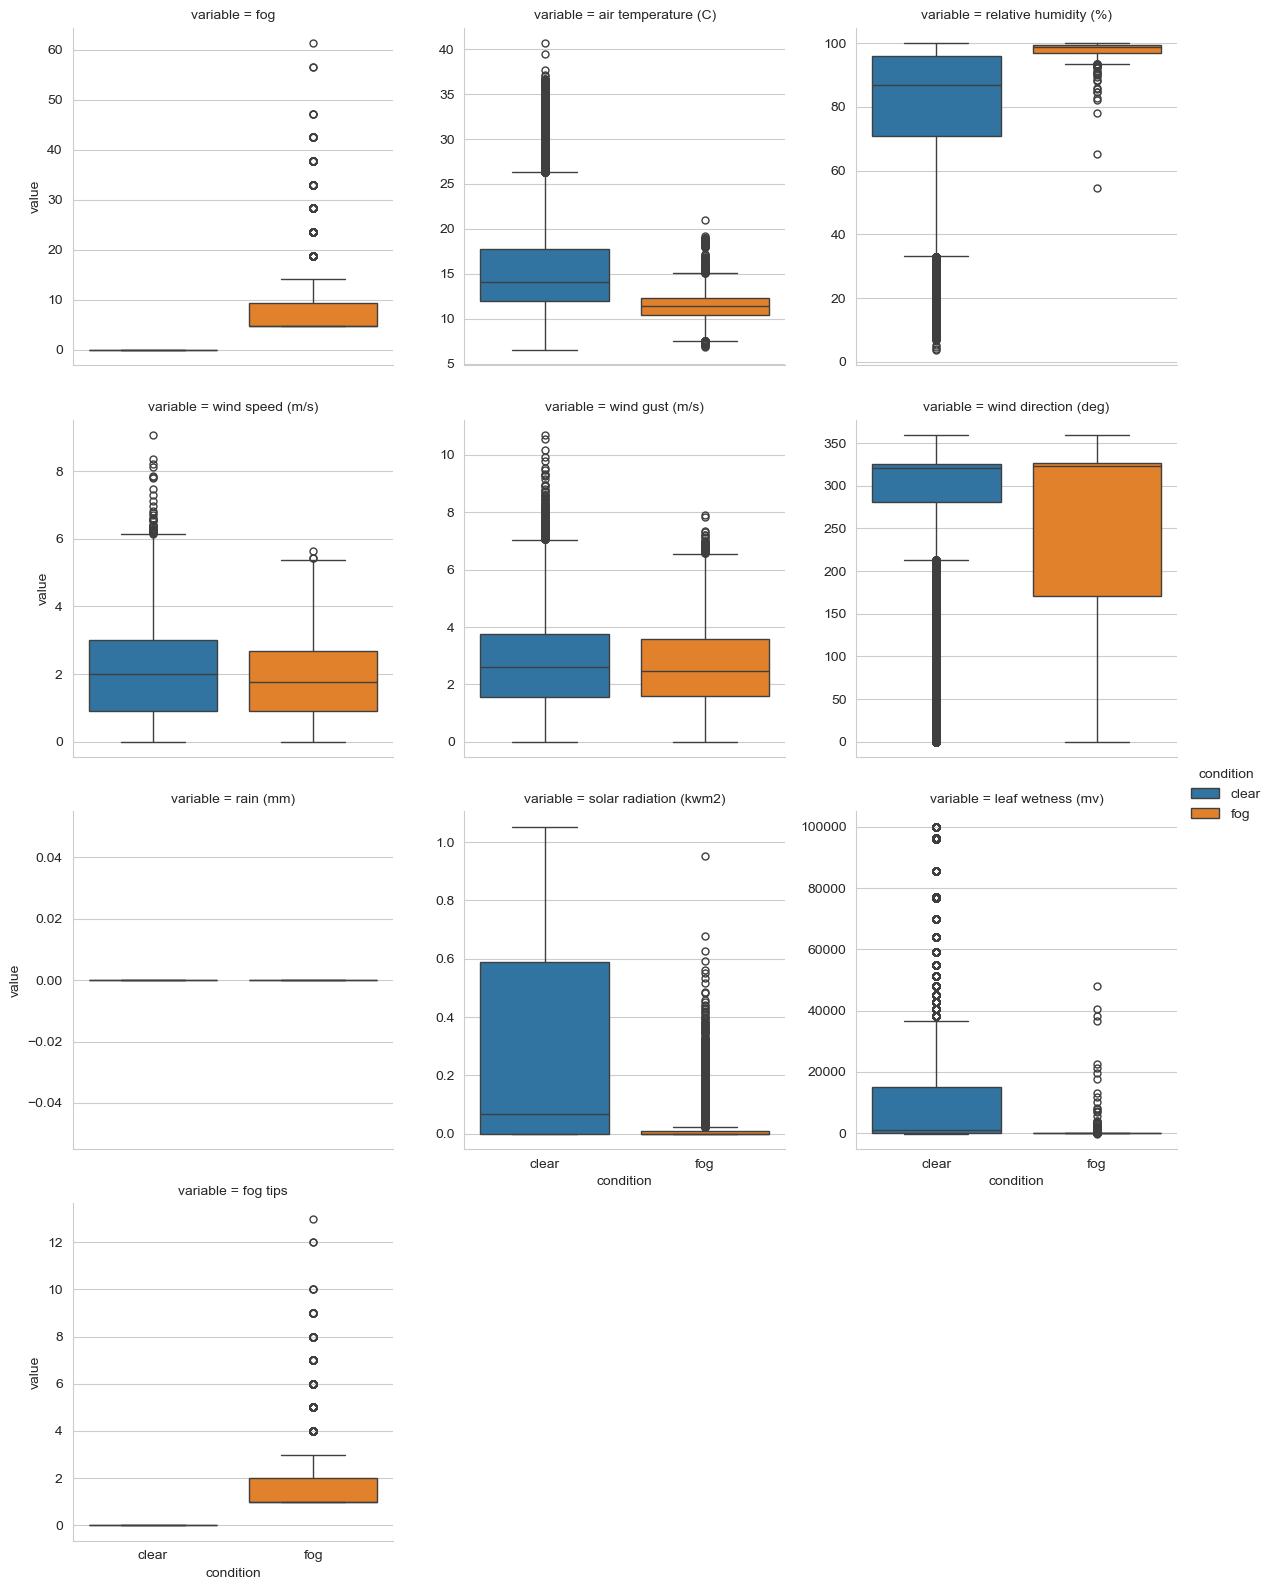

In [20]:
#### Check boxplot distributions ####
# Drop observations classed as rain/both
tmp = df.loc[df['condition'].isin(['clear', 'fog'])]

# Create long form data
value_col = df.columns.drop(['time (PST)', 'condition']).tolist()
df_long = pd.melt(tmp, id_vars=['time (PST)', 'condition'], value_vars=value_col)

# Plot boxplots
sns.catplot(data=df_long, kind='box', col='variable', x='condition', y='value', hue='condition',
            sharey=False, height=4, col_wrap=3, legend='full')

plt.show()


## Correlation Heatmap
No strong linear correlations found for fog drip, but this doesn't say anything about the presence of fog - just the volume of drip.

There's a weak correlation with rain, which reinforces our suspicion that the fog harp is receiving bycatch of rain events. 


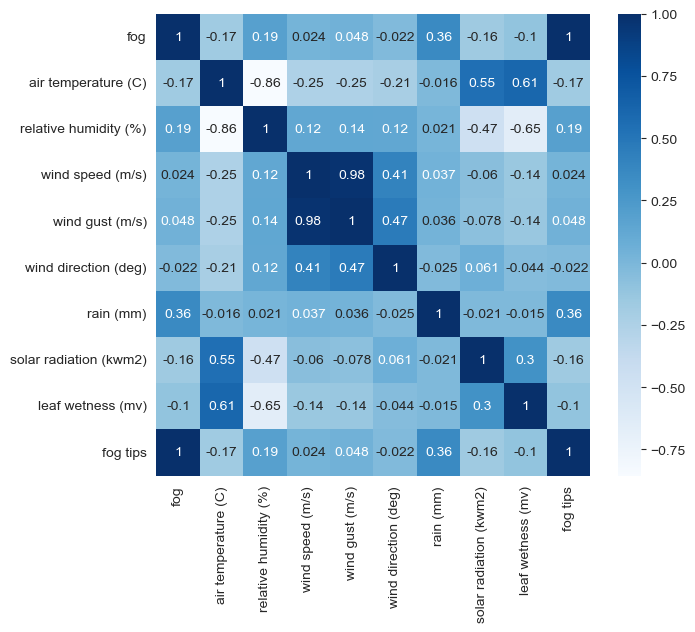

In [22]:
#### Correlation Heatmap ####
fig, ax = plt.subplots(figsize=(7,6))
sns.heatmap(df.drop(['time (PST)', 'condition'], axis=1).corr(),
            annot=True,
            cmap='Blues')
plt.show()

## Fog Drip Temporal Heatmap

Interannual comparison of the temporal trends in fog drip. 

In [28]:
#### Aggregate to hourly data ####
df_hourly = df[['time (PST)','fog tips', 'rain (mm)']].set_index('time (PST)')
df_hourly = df_hourly.resample('h').sum().reset_index()

df_hourly.describe()

,time (PST),fog tips,rain (mm)
count,47496,47496.00,47496.00
mean,2007-01-15 11:30:00,0.25,0.00
min,2004-05-01 00:00:00,0.00,0.00
25%,2005-09-07 17:45:00,0.00,0.00
50%,2007-01-15 11:30:00,0.00,0.00
75%,2008-05-24 05:15:00,0.00,0.00
max,2009-09-30 23:00:00,81.00,8.00
std,NaN,1.57,0.06


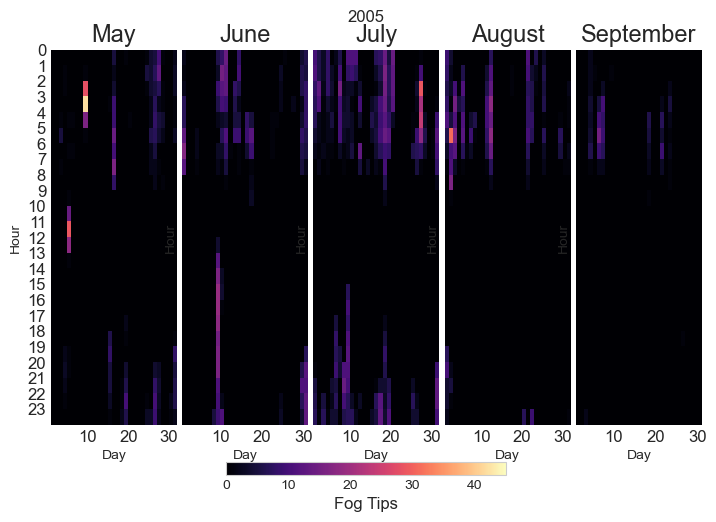

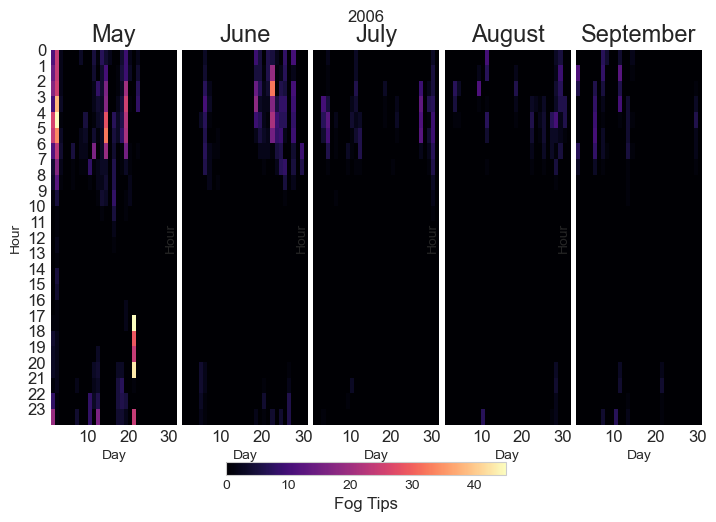

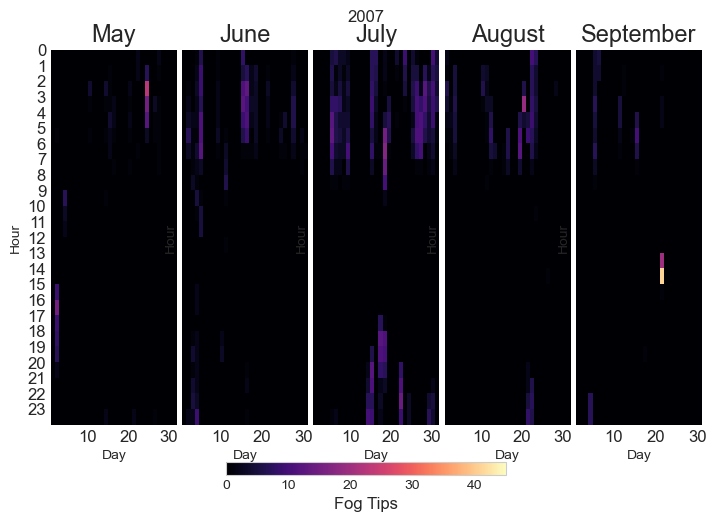

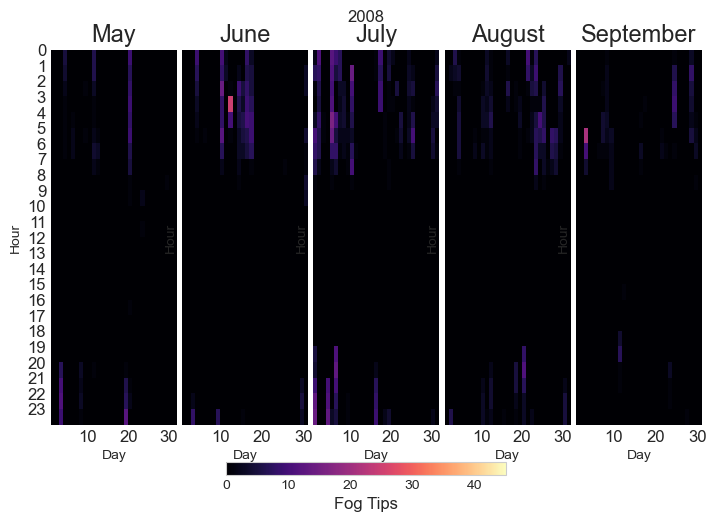

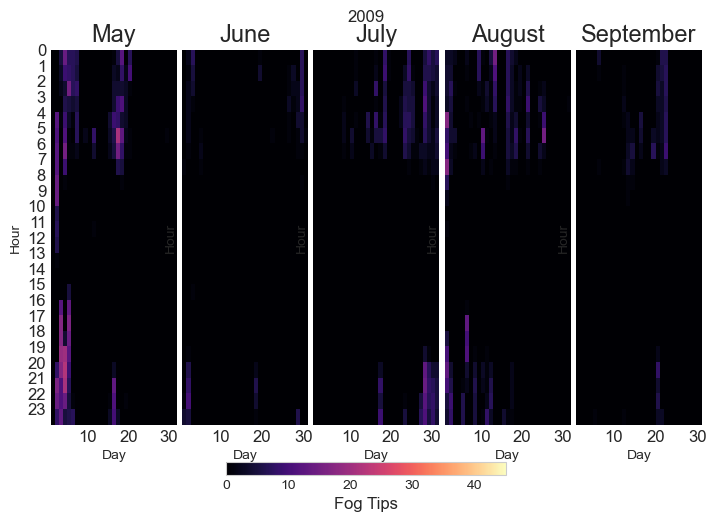

In [33]:
#### Plot Heat Map ####
year = 2005
min_fog = 0
max_fog = 45  # Chosen to highlight overall trend

years = np.arange(2005, 2010).tolist()
for year in years:
    plot_hourly_heatmap(df_hourly, year, min_fog, max_fog)

## Check Relationship between fog and rain
Of observations where rain was recorded, about 1/4 also recorded fog. There's a relatively high correlation between rain and fog.

Total Number Nonzero Rain Observations: 195
Total Number of Nonzero Rain-Zero Fog Observations: 52
Fog/Rain Correlation: 0.659


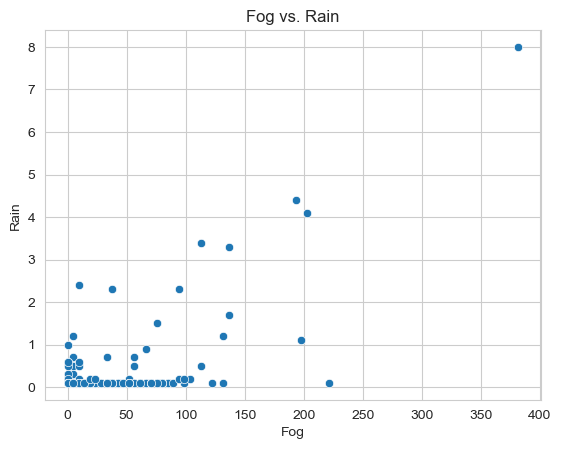

In [24]:
#### Fog/Rain Relationship ####
# Get observation counts
df_hourly_rain = df_hourly.loc[df_hourly['Rain']!=0]
print(f'Total Number Nonzero Rain Observations: {df_hourly_rain.shape[0]}')
print(f'Total Number of Nonzero Rain-Zero Fog Observations: {df_hourly_rain['Fog'].loc[df_hourly_rain['Fog']==0].value_counts()[0]}')

# Get linear correlation
correlation = round(pearsonr(df_hourly_rain['Fog'], df_hourly_rain['Rain'])[0], 3)
print(f'Fog/Rain Correlation: {correlation}')

# Make Plot
sns.scatterplot(df_hourly_rain,
                x='Fog',
                y='Rain')
plt.title('Fog vs. Rain')
plt.show()

### Cumulative sums plots

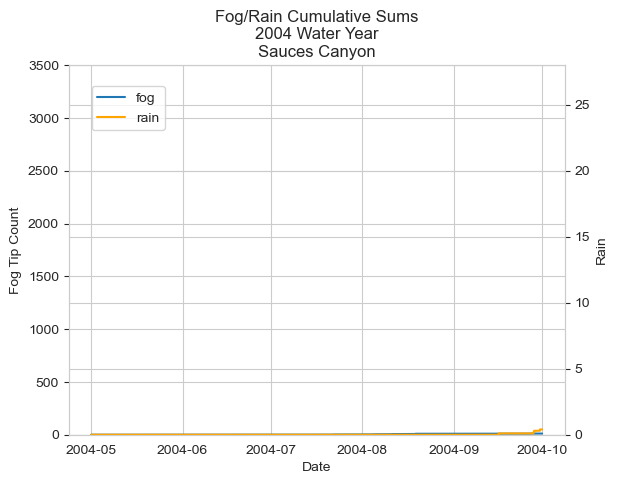

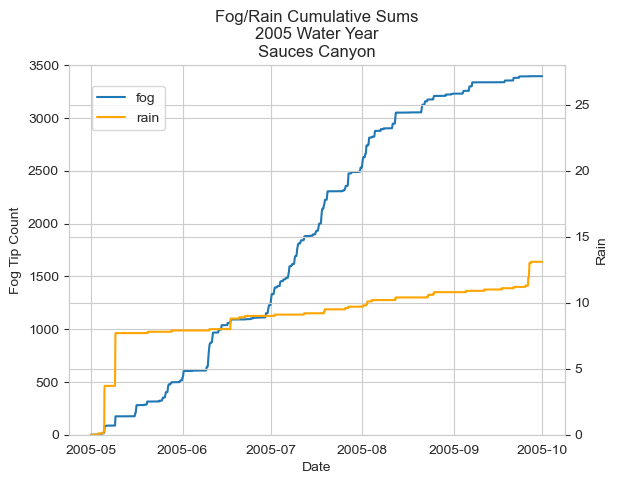

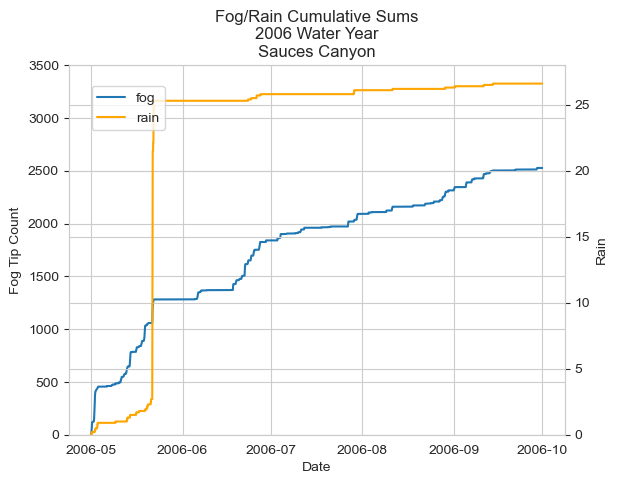

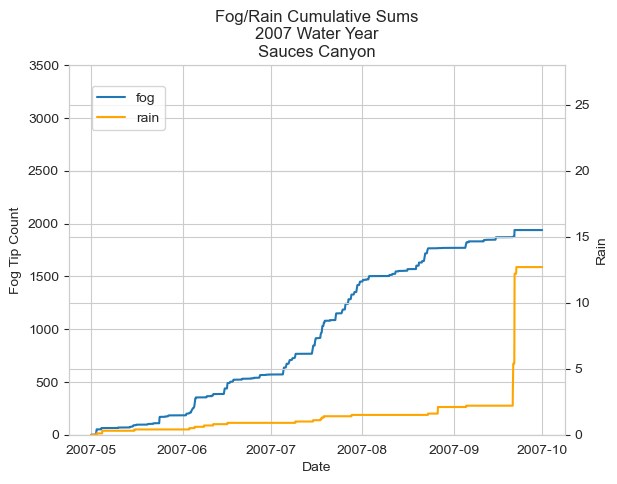

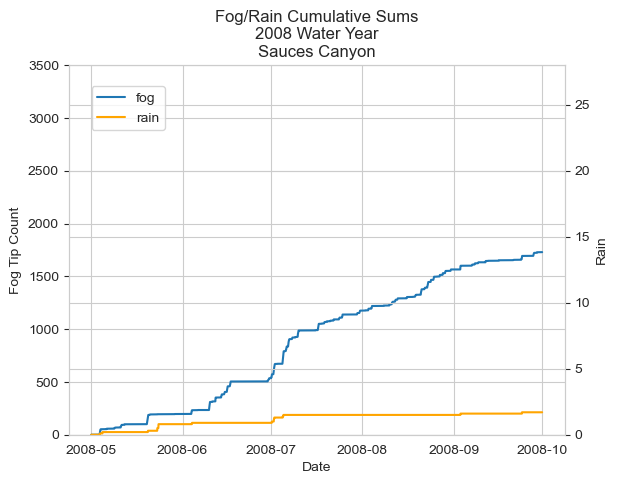

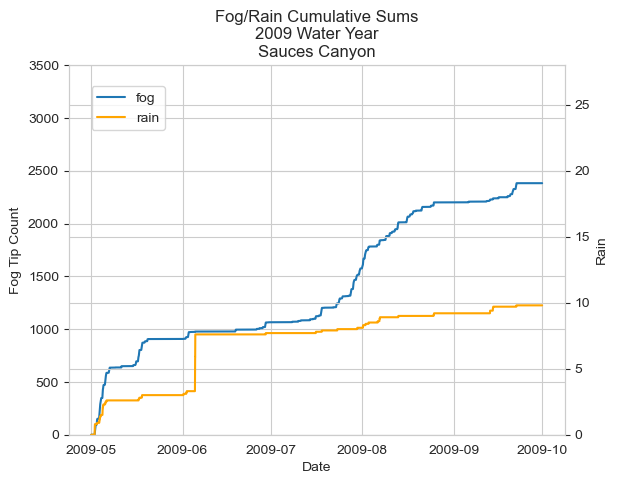

In [52]:
# Make lineplots
years = [2004, 2005, 2006, 2007, 2008, 2009]

for year in years:
    plot_cumsum(df, year)

## Variable Time Series
Could also stratify by month

In [84]:
#### Group data by time ####
tmp = df.copy()

months = [datetime.month for datetime in tmp['time (PST)']]
days = [datetime.day for datetime in tmp['time (PST)']]
times = [str(datetime.time()) for datetime in tmp['time (PST)']]

tmp['month'] = months
tmp['day'] = days
tmp['clock_time'] = times
time_df = tmp[['clock_time', 'fog', 'wind direction (deg)', 'relative humidity (%)']].groupby('clock_time').mean()

time_df.head()
#time_df_gp = df[['clock_time', 'month', 'air_temp_min', 'wind_speed', 'wind_dir']].groupby(['month', 'clock_time']).agg(['mean', 'median', 'min','max'])
#time_df_gp = time_df_gp.reset_index()
#time_df_gp['month_name'] = [calendar.month_name[month] for month in time_df_gp['month']]
#time_df_gp

#time_df_gp.head()

,fog,wind direction (deg),relative humidity (%)
clock_time,,,
00:00:00,1.08,270.22,88.74
00:15:00,1.02,266.73,88.95
00:30:00,1.18,262.90,89.20
00:45:00,1.18,264.75,89.38
01:00:00,1.25,262.19,89.61


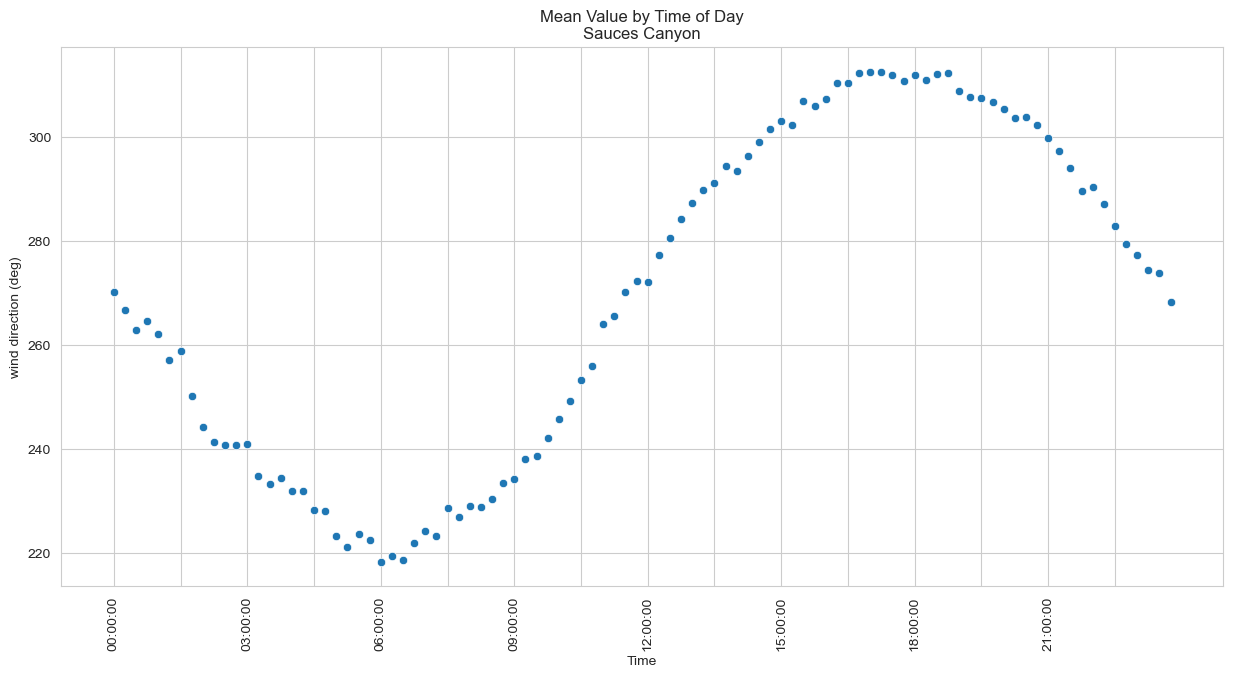

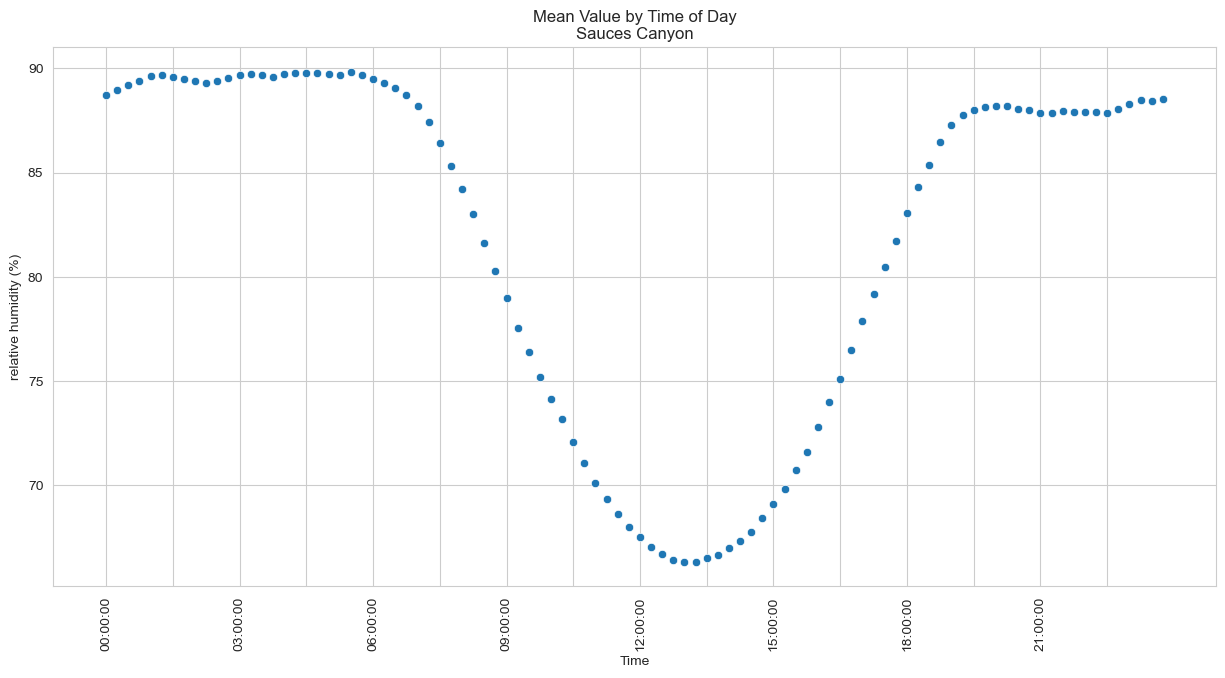

In [94]:
#### Plot wind direction by time of day ####
def plot_agg_time(df, var):
    fig, ax = plt.subplots(figsize=(15,7))
    df = df.reset_index()
    xticks = df['clock_time'][::6]

    sns.scatterplot(data=df, x='clock_time', y=var, ax=ax)

    plt.setp(ax.get_xticklabels()[1::2], visible=False)
    ax.set(title=f"Mean Value by Time of Day\n{df.attrs['site']}",
           ylabel=var,
           xlabel='Time')
    plt.xticks(xticks, rotation=90)

    plt.show()


plot_agg_time(time_df, var='wind direction (deg)')
plot_agg_time(time_df, var='relative humidity (%)')

## Wind Speed vs. Fog Drip

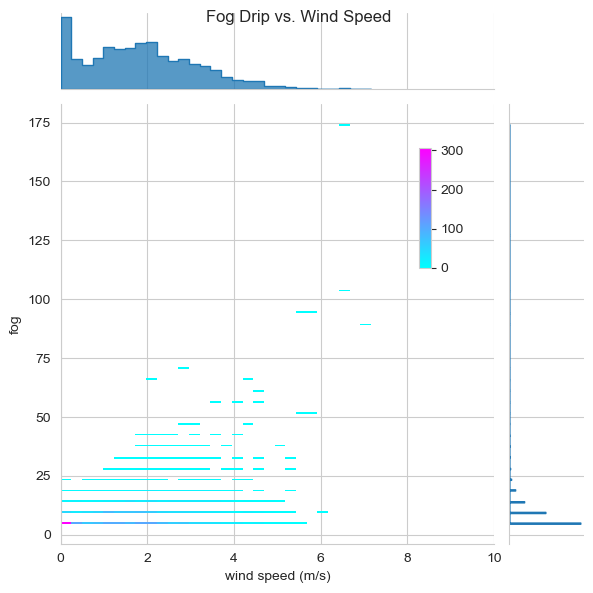

In [100]:
#### Frequency heat map ####
tmp = df.copy()
tmp = tmp.loc[tmp['fog'] != 0]

g = sns.JointGrid(data=tmp,
                  x='wind speed (m/s)',
                  y='fog',
                  xlim=(0,10))

cax = g.figure.add_axes([.7, .55, .02, .2])

g.plot_joint(sns.histplot,
            cmap='cool',
            cbar=True,
            cbar_ax=cax)

g.plot_marginals(sns.histplot, element='step')
plt.suptitle('Fog Drip vs. Wind Speed')
plt.show()